### Trying to predict customer churn through a machine learning algorithm


We build a decision tree to try to predict the customers who will exit the bank. The most important problem we have run into while building ths tree is the small sample of the dataset, which reduced the training sample for the tree. We stratify the tree to obtain representative samples in train and test. We then use accuracy score as the maximising metric to build a CVGridSearch to allow us to pick the best parameters for this model, and we analyse its performance. 

Accuracy is a metric that measures how often a machine learning model correctly predicts the outcome. This accuracy score means that the model correctly predicted the churn status of the customer 85.23% of the instances in the test set.

Precision (also called positive predictive value) is the fraction of customers that exit amongst the predicted exited customers: True Exits / Predicted Exits. Our recall implies that 75% of the people who were predicted by the algorythm to exit were correctly exited.

Recall (also known as sensitivity) is the fraction of the total amount of relevant instances that were actually retrieved: True Exits / Total Exits. Only around 41% of the people who exited in this database were correctly predicted by the model. 

The general acuracy and precision of our model are not bad, especially given the sample size. However, our model fails particularly in its recall. It is not good ar identifying all the people who exited, which poses a problem because this is what we want this algorithm's taks to be in future customer datasets.

To try and improve the recall of our model, we run another grid search for our best parameters using recall as the maximising metric. The resulting tree improves recall score only by 5% while reducing accuracy and precision slightly (around 1% and 5% approximately), which is not a significant difference. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

df = pd.read_csv('churn_bank.csv')
NRows, NColumns = df.shape

### Transforming the database

In [2]:
# convert all variables to their most appropriate type
df = df.convert_dtypes()
df.dtypes
# we can clearly see which variables to change or "dummify": exited, geography and gender

CustomerId                  Int64
Surname            string[python]
CreditScore                 Int64
Geography          string[python]
Gender             string[python]
Age                         Int64
Tenure                      Int64
Balance                   Float64
NumOfProducts               Int64
HasCrCard                   Int64
IsActiveMember              Int64
EstimatedSalary           Float64
Exited                      Int64
dtype: object

In [3]:
# Y variable => to float
df['Exited'] = df['Exited'].astype("float")

# Dummy gender: female = 1, male = 0
df["Gender"] = (df["Gender"] == "Female").astype(int)

# 3 dummy variables for geography
# Making sure the last column is still exit for separating easily later
df.insert(NColumns-1, 'InSpain', (df["Geography"] == "Spain").astype(int))
df.insert(NColumns-1, 'InFrance', (df["Geography"] == "France").astype(int))
df.insert(NColumns-1, 'InGermany', (df["Geography"] == "Germany").astype(int))


In [4]:
# deleting variables we do not care about
df = df.drop(["CustomerId", "Surname", "Geography"], axis=1)

In [5]:
# making sure all values are numeric
df.dtypes

CreditScore          Int64
Gender               int64
Age                  Int64
Tenure               Int64
Balance            Float64
NumOfProducts        Int64
HasCrCard            Int64
IsActiveMember       Int64
EstimatedSalary    Float64
InGermany            int64
InFrance             int64
InSpain              int64
Exited             float64
dtype: object

### Growing the optimal tree

In [7]:
# preparing X and Y
df_Y = df[['Exited']]
df_X = df[df.columns[:NColumns-1]]

In [8]:
# dividing into train and test
df_X_train, df_X_test, df_Y_train, df_Y_test = train_test_split(
    df_X,
    df_Y,
    test_size=0.3,
    random_state=0,
    stratify=df_Y
    )

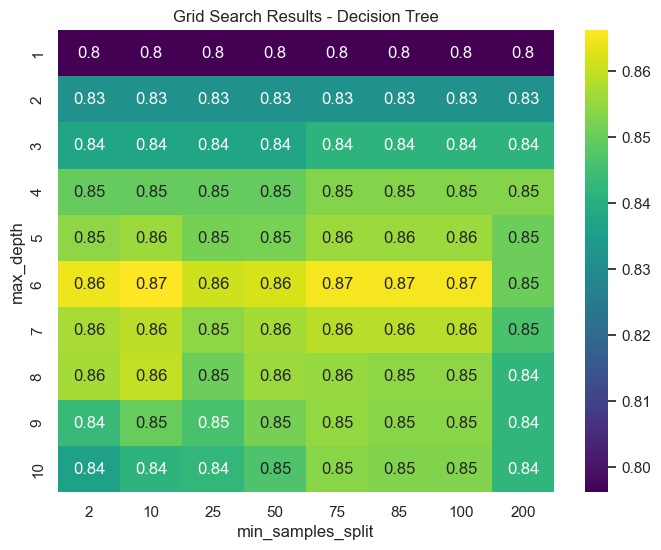

Best Hyperparameters: {'max_depth': 6, 'min_samples_split': 10}


In [9]:
# prepping for GridSearchCV
v_split = StratifiedShuffleSplit(n_splits=1, train_size=0.7, random_state=0)

tree = DecisionTreeClassifier(random_state=0)
param_grid = {'max_depth': range(1, 11),
              'min_samples_split': [2, 10, 25, 50, 75, 85, 100, 200]}

tree_search = GridSearchCV(tree, param_grid, cv=v_split, n_jobs = -1,
                         scoring="accuracy") # how tree performer for each grid of parameters + accuracy better than MSE when binary variables

# we fit it to out data
tree_res = tree_search.fit(df_X_train, df_Y_train.values.ravel()) 

#we plot the grid to see the optimal parameter combination
df = pd.DataFrame(tree_res.cv_results_['params'])
df['mean_test_score'] = tree_res.cv_results_['mean_test_score']
sns.set_theme()
sns.set(rc={'figure.figsize': (8, 6)})
sns.heatmap(df.pivot_table(index='max_depth', columns='min_samples_split',
values='mean_test_score'),
cmap='viridis', annot=True)
plt.title('Grid Search Results - Decision Tree')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.show()

# Get the best hyperparameters
best_params = tree_search.best_params_ # dictionary 

# Get the best model
best_model = tree_search.best_estimator_
predictions = best_model.predict(df_X_test)

# we predict the test and observe the RMSE
print(f"Best Hyperparameters: {best_params}")


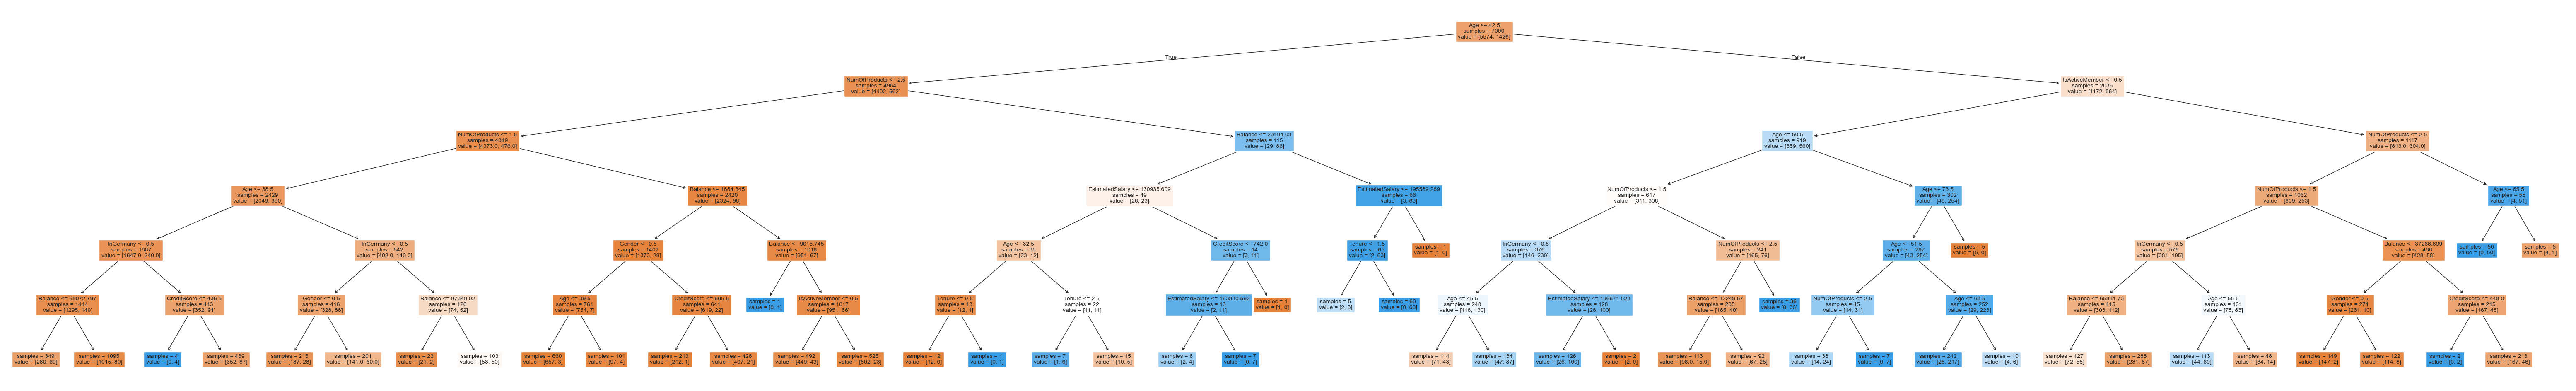

In [10]:
# visualize the tree to see the determining factors
tree = DecisionTreeClassifier(min_samples_split=best_params["min_samples_split"],
                              max_depth = best_params["max_depth"])

tree.fit(df_X_train,df_Y_train)

column_names = df_X.columns.values.tolist()

plt.figure(figsize=(80,12))  # set plot size (denoted in inches)
plot_tree(tree, fontsize=10, feature_names=column_names, filled=True, impurity=False, proportion = False)
plt.show()

### Analysing the performance of our tree

Text(0.5, 1.0, 'Metric: Accuracy')

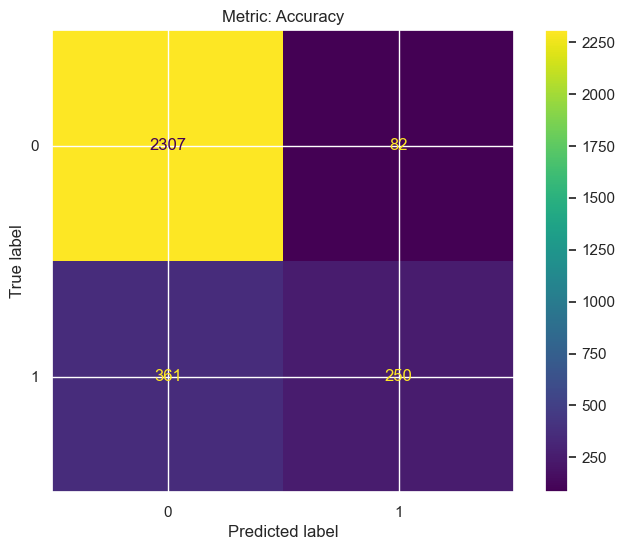

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix(df_Y_test, predictions))
disp.plot()
disp.ax_.set_title("Metric: Accuracy")

In [12]:
print("Accuracy:", accuracy_score(df_Y_test, predictions))
print("Precision:", precision_score(df_Y_test, predictions))
print("Recall:", recall_score(df_Y_test, predictions))

Accuracy: 0.8523333333333334
Precision: 0.7530120481927711
Recall: 0.40916530278232405


Accuracy: 0.8496666666666667
Precision: 0.7030456852791879
Recall: 0.4533551554828151


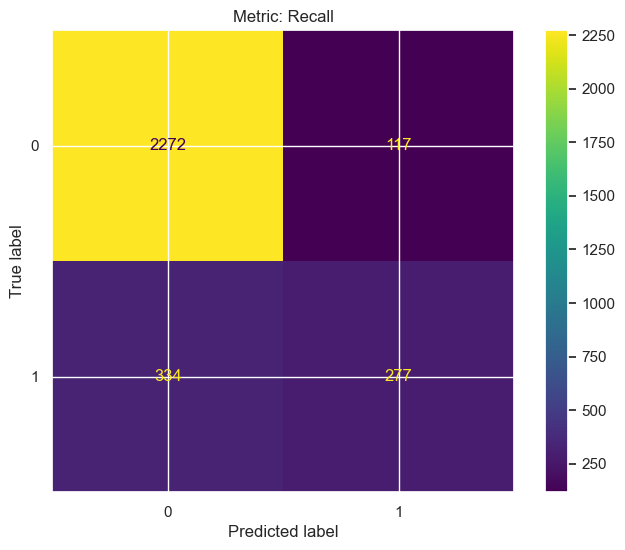

In [13]:
# trying recall as the gridsearch metric
tree_search = GridSearchCV(tree, param_grid, cv=v_split, n_jobs = -1,
                         scoring="recall")
tree_res = tree_search.fit(df_X_train, df_Y_train.values.ravel())
best_model = tree_search.best_estimator_
predictions = best_model.predict(df_X_test)

disp = ConfusionMatrixDisplay(confusion_matrix(df_Y_test, predictions))
disp.plot()
disp.ax_.set_title("Metric: Recall")

print("Accuracy:", accuracy_score(df_Y_test, predictions))
print("Precision:", precision_score(df_Y_test, predictions))
print("Recall:", recall_score(df_Y_test, predictions))

# no significant improvements